<a href="https://colab.research.google.com/github/abyanjan/Natural-language-Processing-NLP-/blob/master/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification with Scikit learn

In [ ]:
!pip install h2o

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [6]:
import re
import nltk
from nltk.stem.porter import PorterStemmer

In [7]:
import h2o
from h2o.automl import H2OAutoML

In [8]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpo0u0vtu1
  JVM stdout: /tmp/tmpo0u0vtu1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpo0u0vtu1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_49is4r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Data**  
Data Related to consumer complaints

In [10]:
df = pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true',compression='zip',sep=',',quotechar='"')

In [11]:
df.shape

(57453, 18)

In [12]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704


Column 'Product' is related to the product type that complaint is related to.  
We will be training a clssification model on the consumer complaints to classify which product type is the complaint related to, so that we can direct the complaint to respective department.

In [13]:
df.Product.value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

We see most of the consumer complaints are related to Debt collection and Credit card and the data is imblanced.

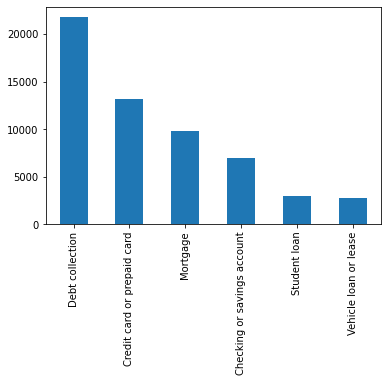

In [14]:
df.Product.value_counts().plot(kind = 'bar')

'Consumer complaint narrative' is the column that has the actual complaint made by the customers. So, we will be using this column as our text data to classify which product type does the complaint belong to.

In [15]:
# selecting the columns ans creating a new data
complaint_df = df[['Consumer complaint narrative','Product','Company']].rename(columns = {'Consumer complaint narrative':'complaints'})

In [16]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [17]:
complaint_df.head()

,complaints,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

Here product is our target variable, so we need to convert it the numerical from text. We will manually convert it to integer.  

We will put classes 'Student loan'and 'Vehicle loan or lease' into a single class since they are very less in number.

In [36]:
target = {'Debt collection': 0, 'Credit card or prepaid card': 1, 'Mortgage': 2, 'Checking or savings account': 3, 'Student loan': 4, 'Vehicle loan or lease':4}

In [37]:
complaint_df['target'] = complaint_df['Product'].map(target)

In [38]:
complaint_df.head()

,complaints,Product,Company,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,4
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,4
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked

**Train Test Split**

In [39]:
X_train, X_test = train_test_split(complaint_df, test_size = 0.3, random_state = 11)

In [22]:
X_train.shape, X_test.shape

((40217, 4), (17236, 4))

**Data Processing/ Cleaning**

In [23]:
# Stemming
stemmer = nltk.stem.SnowballStemmer('english')

In [24]:
# stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
# word tokenization function
def tokenize(text):
  tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+','', word.strip('Xx/'))) > 2)]
  tokens = map(str.lower, tokens)
  stems = [stemmer.stem(word) for word in tokens if (word not in stop_words)]
  return stems

In [26]:
# creating TFIDf vectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenize, lowercase=False, stop_words=None, max_df=0.75, max_features=1000,ngram_range=(1,2))

In [27]:
# fitting the vectorizer to the train data
train_vector = vectorizer.fit_transform(X_train.complaints)

In [29]:
# sparse matrix after fitting the vectorizer
train_vector.A

array([[0.        , 0.04715581, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08498819],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [31]:
# example of features extracted
vectorizer.get_feature_names()[1:20]

['abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru']

In [32]:
# transform test data with the vectorizer
test_vector = vectorizer.transform(X_test.complaints)

Converting the train and test vectors to pandas data frame.

In [40]:
train_df = pd.DataFrame(train_vector.toarray(), columns=vectorizer.get_feature_names())
# adding the target variable
train_df = pd.concat([train_df, X_train['target'].reset_index(drop = True)], axis = 1)
train_df.head()

,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,agenc,...,verifi,victim,victim ident,violat,visa,visit,voicemail,wait,waiv,want,wasnt,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.047156,0.0,0.0,0.0,0.0,0.0,0.023709,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.053082,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.120568,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10051,0.0,0.0,0.133295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084988,1
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.156405,0.0,0.0,0.0,0.0,0.069568,0.0,0.0,0.0,0.0,0.161973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08209,0.0,0.0,0.000000,0.0,0.0,0.0,0.053188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2


In [45]:
test_df = pd.DataFrame(test_vector.toarray(), columns=vectorizer.get_feature_names())
# adding the target variable
test_df = pd.concat([test_df, X_test['target'].reset_index(drop = True)], axis = 1)


**Using H2o AutoMl to select the best model for the classification**

In [47]:
# converting pandas datafame to h2o data frame
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


H2o requires the target feature to be as factor for classification, so we will need to convert the target feature to factor, which is integer now.

In [48]:
h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()

In [50]:
# Auto ml
auto_ml = H2OAutoML(max_models=10,seed=10, exclude_algos=['StackedEnsemble'], nfolds=0, verbosity='info', balance_classes=True, max_after_balance_size=0.3)

In [51]:
# setting the input and output variable
x = vectorizer.get_feature_names()
y = 'target'

In [52]:
# fitting the automl
auto_ml.train(x = x, y = y, training_frame=h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
11:13:43.713: Project: AutoML_20200828_111343706
11:13:43.714: Cross-validation disabled by user: no fold column nor nfolds > 1.
11:13:43.726: Setting stopping tolerance adaptively based on the training frame: 0.004986492434129795
11:13:43.726: Build control seed: 10
11:13:43.726: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
11:13:48.809: training frame: Frame key: automl_training_py_1_sid_b23d    cols: 1001    rows: 36098  chunks: 47    size: 30154010  checksum: 585415598306281603
11:13:48.817: validation frame: Frame key: py_2_sid_b23d    cols: 1001    rows: 17236  chunks: 20    size: 14218472  checksum: 6548829584427854918
11:13:49.217: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_b23d    cols: 1001    rows: 4119  chunks: 47    size: 6661961  checksum: 1591610272059144283
11:13:49.217: blending frame: NULL
11:13:49.217: response 

In [54]:
auto_ml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_3_AutoML_20200828_111343,0.124996,0.319505,0.308676,0.095281
XGBoost_1_AutoML_20200828_111343,0.126273,0.322367,0.30746,0.0945314
XGBoost_2_AutoML_20200828_111343,0.126942,0.317474,0.30339,0.0920454
GBM_3_AutoML_20200828_111343,0.134589,0.370102,0.334181,0.111677
GBM_4_AutoML_20200828_111343,0.136417,0.371372,0.333893,0.111485
GBM_2_AutoML_20200828_111343,0.138775,0.371468,0.336831,0.113455
GLM_1_AutoML_20200828_111343,0.13934,0.365973,0.328923,0.10819
GBM_5_AutoML_20200828_111343,0.140217,0.3614,0.330527,0.109248
GBM_1_AutoML_20200828_111343,0.144226,0.377941,0.341305,0.116489
DRF_1_AutoML_20200828_111343,0.196057,0.5635,0.434066,0.188414


Here the best model is the Xgboost model.

In [55]:
# selecting the best model
best_model = auto_ml.leader

In [61]:
# confusion matrix on the test data
best_model.confusion_matrix(h2o_train_df)


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,Error,Rate
0,14731.0,266.0,91.0,54.0,134.0,0.035677,"545 / 15,276"
1,342.0,8660.0,17.0,143.0,29.0,0.057774,"531 / 9,191"
2,106.0,55.0,6592.0,19.0,51.0,0.033856,"231 / 6,823"
3,98.0,173.0,12.0,4622.0,9.0,0.059422,"292 / 4,914"
4,237.0,125.0,25.0,16.0,3610.0,0.100424,"403 / 4,013"
5,15514.0,9279.0,6737.0,4854.0,3833.0,0.049780,"2,002 / 40,217"


In [65]:
# converting xgboost h2o parameters  to actual xgboost parameters
best_model.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_bin': 256,
  'max_delta_step': 0.0,
  'max_depth': 5,
  'min_child_weight': 3.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 5,
  'objective': 'multi:softprob',
  'seed': 12,
  'silent': True,
  'subsample': 0.8,
  'updater': 'grow_gpu_hist'},
 10000)

**Training Xgboost model**

In [66]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.05, objective='multi:softprob',random_state=10,**{'updater':'grow_gpu'})

In [69]:
xgb_clf.fit(train_vector, X_train['target'])

[12:43:45] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [70]:
# prediction on test data
pred = xgb_clf.predict(test_vector)

In [72]:
# confusion matrix
cm = confusion_matrix(X_test['target'], pred)
print(cm)

[[5938  250   71   68  169]
 [ 386 3375   16  176   49]
 [ 142   53 2611   39  131]
 [ 134  202   22 1715   16]
 [ 260  107   51   22 1233]]


In [73]:
# classification report
print(classification_report(X_test['target'], pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      6496
           1       0.85      0.84      0.84      4002
           2       0.94      0.88      0.91      2976
           3       0.85      0.82      0.83      2089
           4       0.77      0.74      0.75      1673

    accuracy                           0.86     17236
   macro avg       0.85      0.84      0.85     17236
weighted avg       0.86      0.86      0.86     17236



From the classification report we can see that for some classes the performance is low, expecially for minority class 3 and 4 as a result of unbalanced data. We can assign class weights so that the model give more importance to minority classes.

In [74]:
from sklearn.utils import class_weight

In [75]:
class_weights = list(class_weight.compute_class_weight('balanced', np.unique(X_train['target']), X_train['target']))

In [84]:
pd.DataFrame( class_weights, columns= ['Weights'])

,Weights
0,0.526538
1,0.875139
2,1.178866
3,1.636834
4,2.004336


Now here each class has a weight and we see for minority classes the weights are higher.

In [77]:
weights = np.ones(X_train.shape[0], dtype='float')

In [78]:
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [79]:
for i, val in enumerate(X_train['target']):
  weights[i] = class_weights[val]

In [80]:
weights

array([0.87513872, 0.87513872, 0.52653836, ..., 2.00433591, 0.52653836,
       0.52653836])

In [85]:
# Retraining the xgboost model with the class weights
xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.05, objective='multi:softprob',random_state=10,**{'updater':'grow_gpu'})

In [86]:
xgb_clf.fit(train_vector, X_train['target'], sample_weight=weights)

[13:07:14] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [91]:
# Accuracy
print(f'Accuracy : {xgb_clf.score(test_vector, X_test["target"])}')

Accuracy : 0.8586679043861685


In [92]:
# predictions on test data
pred = xgb_clf.predict(test_vector)

In [93]:
print(classification_report(X_test['target'], pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      6496
           1       0.86      0.83      0.84      4002
           2       0.94      0.88      0.91      2976
           3       0.78      0.88      0.83      2089
           4       0.66      0.85      0.74      1673

    accuracy                           0.86     17236
   macro avg       0.83      0.86      0.84     17236
weighted avg       0.87      0.86      0.86     17236



Compared to earlier, here we have now achieved better recall for the minority classes, but also the recall has decreased for majority class. However, we have now a balanced result, so our model is not biased towards the majority class.  
We can further improve the performance with hyperparameter tuning.